### Based on Gene Kogan's ml4a guides: https://github.com/ml4a/ml4a-guides   
#### http://genekogan.com/

# Image t-SNE

This notebook will take you through the process of generating a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) of a set of images, using a feature vector for each image derived from the activations of the last fully-connected layer in a pre-trained convolutional neural network (convnet).

### Installation and dependencies

The code for this notebook has a number of dependencies, which can usually be installed with `pip`. You will need:

 * [simplejson](https://pypi.python.org/pypi/simplejson/)
 * [matplotlib](http://matplotlib.org)
 * [scikit-learn](scikit-learn.org)
 * [Pillow](https://python-pillow.org/)
 * [cPickle](https://docs.python.org/2/library/pickle.html)
 * [tqdm](https://pypi.python.org/pypi/tqdm)
 
Additionally, if you'd like to follow the last section which converts the t-SNE points to a grid assignment, you'll need [RasterFairy](https://github.com/Quasimondo/RasterFairy), which can be installed with `pip` in with the following command.

    pip install git+https://github.com/Quasimondo/RasterFairy

### Prepare dataset

This notebook assumes you have already extracted features for a directory of images and saved them to disk. If you haven't done this yet, see the previous notebook [reverse image search](image-search.ipynb), which shows you how to do this. Alternatively, you may [download the pre-analyzed vectors](https://drive.google.com/drive/folders/0B3WXSfqxKDkFYm9GMzlnemdEbEE?usp=sharing), along with the images from [Caltech-101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/) by running:

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
Or you can run the `download.sh` script in the `data` folder which will automatically download this dataset for you, along with all the other materials for these notebooks.

Since its hard to fit too many images in a visualization at the same time, it works best to use just several hundred or a thousand images, but in principle, it can work with any number of images. In this example, we will use 1000.

Now we can begin. Run the following import commands and make sure all the libraries are correctly installed and import without errors.

In [1]:
import sys
print(sys.version)

2.7.15 |Anaconda custom (64-bit)| (default, May  1 2018, 23:32:55) 
[GCC 7.2.0]


In [2]:
!pwd

/home/ubuntu/Projects/Embeddings


In [3]:
#!pip install git+https://github.com/Quasimondo/RasterFairy --user
#!pip install sklearn
#!pip install tqdm

In [4]:
%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt

#import cPickle as pickle
import pickle

from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE
from tqdm import tqdm
from IPython.display import clear_output

First, we will load our image paths and feature vectors from the previous notebook into memory. We can print their contents to get an idea of what they look like:

In [6]:
images, pca_features = pickle.load(open('./results/features_caltech101.pickle', 'rb'))

for i, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

image: ./data/101_ObjectCategories/chandelier/image_0017.jpg, features: -2.26,-14.77,-5.71,0.51... 
image: ./data/101_ObjectCategories/chandelier/image_0054.jpg, features: 2.85,-6.12,3.53,-3.49... 
image: ./data/101_ObjectCategories/chandelier/image_0063.jpg, features: -5.51,-3.73,-1.93,-4.05... 
image: ./data/101_ObjectCategories/chandelier/image_0097.jpg, features: -1.43,-3.70,-0.62,1.15... 
image: ./data/101_ObjectCategories/chandelier/image_0051.jpg, features: -3.93,3.91,-6.23,3.52... 


In our dataset that we've loaded, there are 9144 images. Although in principle, t-SNE works with any number of images, it's difficult to place that many tiles in a single image. So instead, we will take a random subset of 1000 images and plot those on a t-SNE instead. This step is optional.

In [7]:
num_images_to_plot = 1000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

It is usually a good idea to first run the vectors through a faster dimensionality reduction technique like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project your data into an intermediate lower-dimensional space before using t-SNE. This improves accuracy, and cuts down on runtime since PCA is more efficient than t-SNE. Since we have already projected our data down with PCA in the previous notebook, we can proceed straight to running the t-SNE on the feature vectors. Run the command in the following cell, taking note of the arguments:

- `n_components` is the number of dimensions to project down to. In principle it can be anything, but in practice t-SNE is almost always used to project to 2 or 3 dimensions for visualization purposes.
- `learning_rate` is the step size for iterations. You usually won't need to adjust this much, but your results may vary slightly. 
- `perplexity` refers to the number of independent clusters or zones t-SNE will attempt to fit points around. Again, it is relatively robust to large changes, and usually 20-50 works best. 
- `angle` controls the speed vs accuracy tradeoff. Lower angle means better accuracy but slower, although in practice, there is usually little improvement below a certain threshold.

In [8]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.006s...
[t-SNE] Computed neighbors for 1000 samples in 0.598s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 21.169920
[t-SNE] Computed conditional probabilities in 0.262s
[t-SNE] Iteration 50: error = 71.5585175, gradient norm = 0.2791492 (50 iterations in 1.678s)
[t-SNE] Iteration 100: error = 71.2048721, gradient norm = 0.2424470 (50 iterations in 1.525s)
[t-SNE] Iteration 150: error = 70.1211395, gradient norm = 0.2727491 (50 iterations in 1.436s)
[t-SNE] Iteration 200: error = 70.8529816, gradient norm = 0.2658578 (50 iterations in 1.444s)
[t-SNE] Iteration 250: error = 70.6144104, gradient norm = 0.2648492 (50 iterations in 1.438s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.614410
[t-SNE] Iteration 300: error = 1.1663265, gradient norm = 0.0017718 (50 iterations in 1.298s)
[t-SNE] Iteration 350: error = 1.0597430, gradient norm = 0.0005

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable `tsne` contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [9]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

Finally, we will compose a new RGB image where the set of images have been drawn according to the t-SNE results. Adjust `width` and `height` to set the size in pixels of the full image, and set `max_dim` to the pixel size (on the largest size) to scale images to.

In [10]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

100%|██████████| 1000/1000 [00:02<00:00, 341.93it/s]


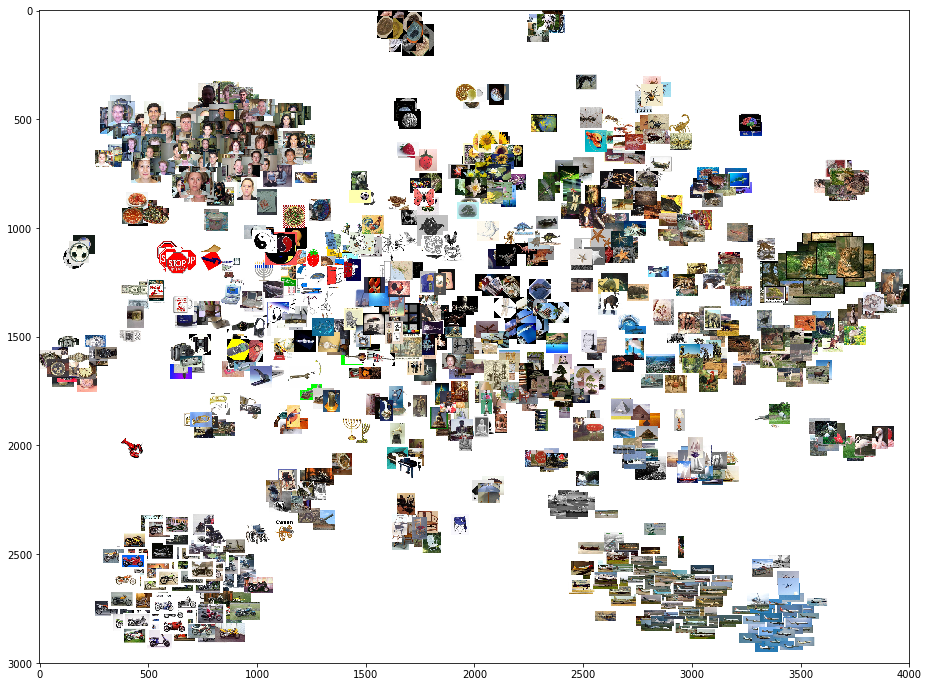

In [11]:
plt.figure(figsize = (16,12))
imshow(full_image)

You can save the image to disk:

In [12]:
full_image.save("./results/example-tSNE-animals1k.png")

Now that we have generated our t-SNE, one more nice thing we can optionally do is to take the 2d embedding and assign it to a grid, using [RasterFairy](https://github.com/Quasimondo/RasterFairy). We can optionally choose a grid size of rows (`nx`) and columns (`ny`), which should be equal to the number of images you have. If it is less, then you can simply cut the `tsne` and `images` lists to be equal to `nx * ny`.

If you omit the `target=(nx, ny)` argument, RasterFairy will automatically choose an optimal grid size to be as square-shaped as possible. RasterFairy also has options for embedding them in a grid with irregular borders as well (see the GitHub page for more details).

You can also save the t-SNE points and their associated image paths for further processing in another environment.

In [13]:
tsne_path = "./results/example-tSNE-points-animals.json"

data = [{"path":os.path.abspath(img), "point":[x.astype("float64"), y.astype("float64")]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to ./results/example-tSNE-points-animals.json


In [14]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

Now finally, we can make a new image of our grid. Set the `tile_width` and `tile_height` variables according to how big you want the individual tile images to be. The resolution of the output image is `tile_width * nx` x `tile_height * ny`. The script will automatically center-crop all the tiles to match the aspect ratio of `tile_width / tile_height`.

In [15]:
grid_assignment[0].shape

(1000, 2)

In [16]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny

print(full_width)
print(full_height)

2880
1400


In [17]:

aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in tqdm(zip(images, grid_assignment[0])):
    #print(grid_pos)
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))


100%|██████████| 1000/1000 [00:02<00:00, 413.25it/s]


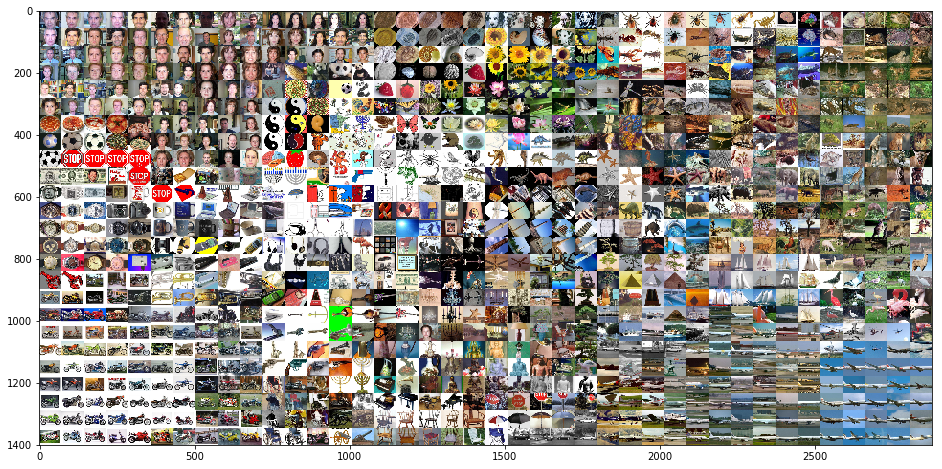

In [18]:
plt.figure(figsize = (16,12))
imshow(grid_image)

Finally, we can save the gridded t-SNE to disk as well.

In [19]:
grid_image.save("./results/example-tSNE-grid-animals.jpg")

## Let us make an animation ##


In [20]:
print(grid_assignment[0].shape)

(1000, 2)


In [21]:
print(nx,ny)

(40, 25)


In [24]:
#!pip install pytweening
import pytweening

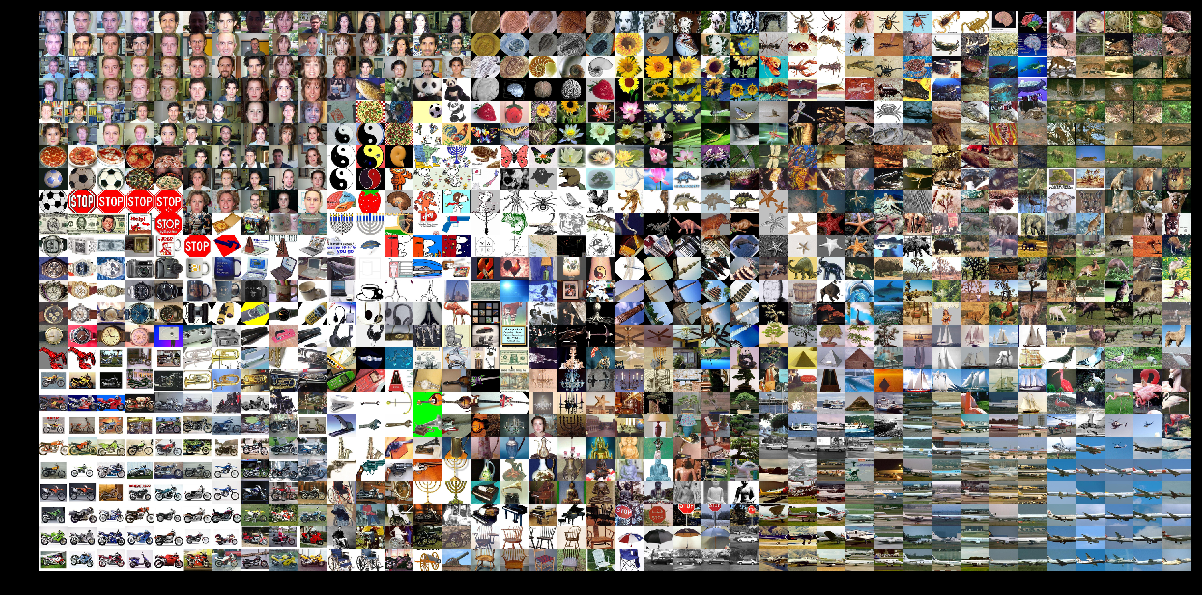

In [26]:
width = full_width #2880 it could be any number
height = full_height #1400 it could be any number
max_dim = 100

print(full_width)
print(full_height)

steps =50

for i in range(steps):
    print(i)
    pctg = pytweening.easeInOutSine(float(i)/(steps-1))
    
    print(pctg)
    
    full_image = Image.new('RGBA', (width, height))

    for img, x,y, grid_pos in tqdm(zip(images, tx, ty, grid_assignment[0])):
        #print(grid_pos)
        idx_x, idx_y = grid_pos
        new_xpos = (width-max_dim)*x*(1-pctg)+pctg*(tile_width * idx_x+width/2-full_width/2)
        new_ypos = (height-max_dim)*y*(1-pctg)+pctg*(tile_height * idx_y+height/2-full_height/2)
        tile = Image.open(img)
        tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
        if (tile_ar > aspect_ratio):
            margin = 0.5 * (tile.width - aspect_ratio * tile.height)
            tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
        else:
            margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
            tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
        tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
        full_image.paste(tile, (int(new_xpos), int(new_ypos)))

    fig = plt.figure(figsize=(16.0,16.0))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(0,0,1,1)

    
    plt.axis("off")
    plt.margins(0.0)
    

    fig.patch.set_facecolor('black')
    
    #plt.rcParams['axes.facecolor']='black'
    plt.rcParams['savefig.facecolor']='black'

    #ax.set_facecolor('black')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    #ax.axes.set_xlim([0.0,dim])
    #ax.axes.set_ylim([0.0,dim])
    #ax.invert_yaxis()
    imshow(full_image)
    clear_output(wait=True)
    plt.savefig('tmpdir/tsne_anim'+"%03d" % (i,)+'.png',bbox_inches="tight")
    plt.show()



In [31]:
import os
frames_dir = './tmpdir'
video_path = './results/tsne_anim_video.mp4'

In [35]:
cmd = 'ffmpeg -i %s/tsne_anim%%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" %s' % (frames_dir, video_path)
print(cmd)
os.system(cmd)

ffmpeg -i ./tmpdir/tsne_anim%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" ./results/tsne_anim_video.mp4


0

## Let us make an animation using masks ##

In [36]:
totalDataPoints=1000
radius,adjustmentFactor,count = rasterfairy.getBestCircularMatch(totalDataPoints)
print "The smallest circle that can hold",totalDataPoints,"has a radius of",radius,"and will fit",count,"points"

The smallest circle that can hold 1000 has a radius of 18 and will fit 1005 points


In [37]:
#the adjustmentFactor is a value between 0.0 and 1.0 that controls
#if a pixel that is on the edge of the circle will be included or not
arrangement = rasterfairy.getCircularArrangement(radius,adjustmentFactor)

In [38]:
rasterMask = rasterfairy.arrangementToRasterMask(arrangement)

In [39]:
grid_xy,(emb_width,emb_height) = rasterfairy.transformPointCloud2D(tsne,target=rasterMask,autoAdjustCount = True)


In [40]:
grid_xy[0]

array([12., 22.], dtype=float32)

In [41]:
width = emb_width*tile_width
print(width)
height = emb_height*tile_height
print(height)

2520
2072


In [42]:
print(tile_width,tile_height)

(72, 56)


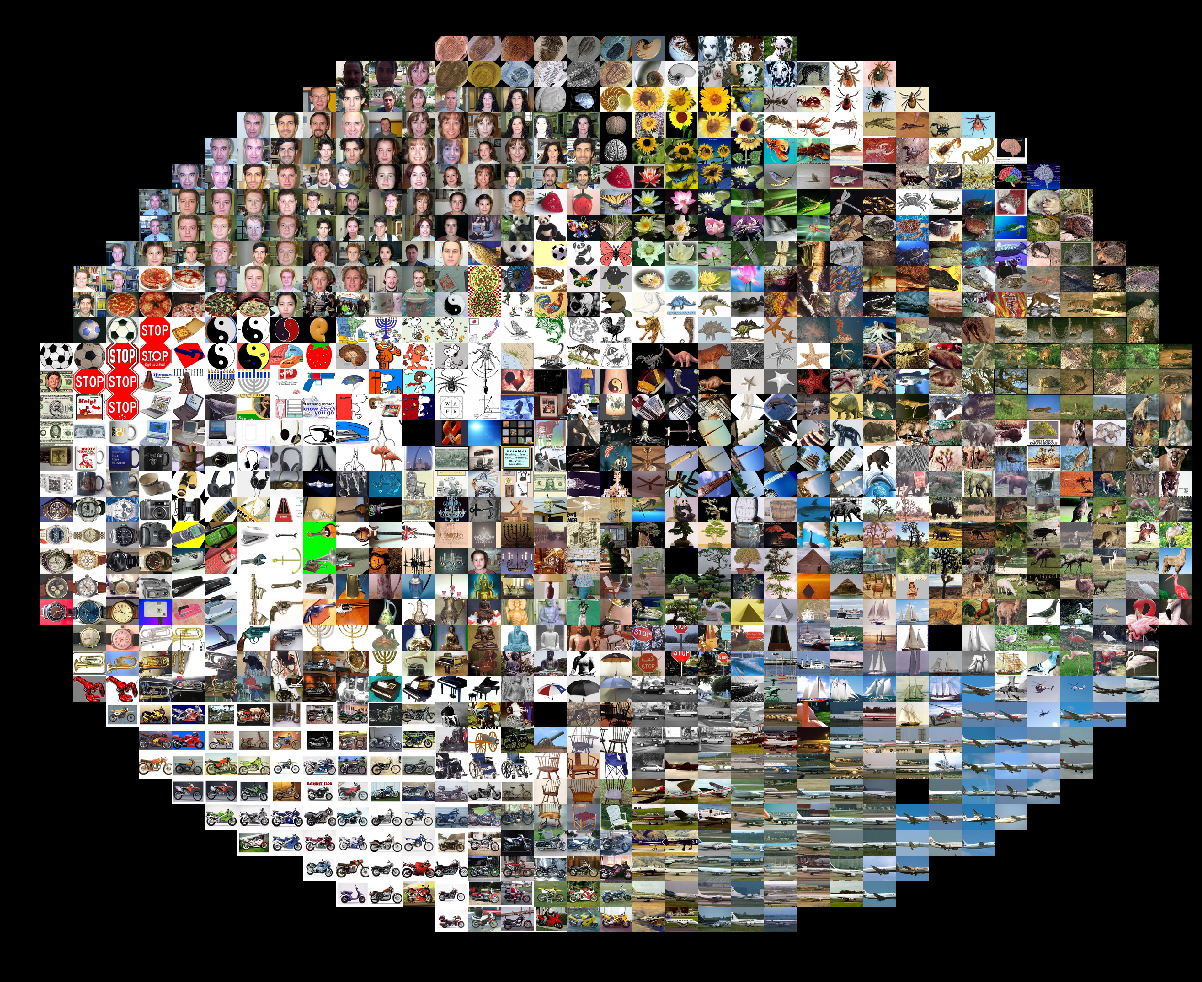

In [43]:
max_dim = 100

print(full_width)
print(full_height)

steps =50

for i in range(steps):
    print(i)
    pctg = pytweening.easeInOutSine(float(i)/(steps-1))
    
    print(pctg)
    
    full_image = Image.new('RGBA', (width, height))

    for img, x,y, grid_pos in tqdm(zip(images, tx, ty, grid_xy)):
        #print(grid_pos)
        idx_x, idx_y = grid_pos
        new_xpos = (width-max_dim)*x*(1-pctg)+pctg*(tile_width * idx_x)
        new_ypos = (height-max_dim)*y*(1-pctg)+pctg*(tile_height * idx_y)
        tile = Image.open(img)
        tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
        if (tile_ar > aspect_ratio):
            margin = 0.5 * (tile.width - aspect_ratio * tile.height)
            tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
        else:
            margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
            tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
        tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
        full_image.paste(tile, (int(new_xpos), int(new_ypos)))

    fig = plt.figure(figsize=(16.0,16.0))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(0,0,1,1)

    
    plt.axis("off")
    plt.margins(0.0)
    

    fig.patch.set_facecolor('black')
    
    #plt.rcParams['axes.facecolor']='black'
    plt.rcParams['savefig.facecolor']='black'

    #ax.set_facecolor('black')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    #ax.axes.set_xlim([0.0,dim])
    #ax.axes.set_ylim([0.0,dim])
    #ax.invert_yaxis()
    imshow(full_image)
    clear_output(wait=True)
    plt.savefig('tmpdir/tsne_circle_anim'+"%03d" % (i,)+'.png',bbox_inches="tight")
    plt.show()




In [44]:
import os
frames_dir = './tmpdir'
video_path = './results/tsne_circle_anim_video.mp4'

cmd = 'ffmpeg -i %s/tsne_circle_anim%%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" %s' % (frames_dir, video_path)
print(cmd)
os.system(cmd)

ffmpeg -i ./tmpdir/tsne_circle_anim%03d.png -c:v libx264 -pix_fmt yuv420p -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" ./results/tsne_circle_anim_video.mp4


0